In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns;sns.set()
from datetime import datetime
import traceback
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# PREPROCESSING CSV

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/dataset_multiclass_ml.csv')
detailed_labels = df['detailed_label']

In [ ]:
class_encoding = {
    "-" : 0,
    "C&C" : 1,
    "C&C-FileDownload" : 2,
    "C&C-HeartBeat" : 3,
    "C&C-HeartBeat-Attack" : 4,
    "C&C-HeartBeat-FileDownload" : 5,
    "C&C-Torii" : 6,
    "DDoS" : 7,
    "FileDownload" : 8,
    "Okiru" : 9,
    "PartOfAHorizontalPortScan" : 10,
    "C&C-PartOfAHorizontalPortScan" : 11,
    "Attack" : 12
}

In [ ]:
encoded_labels = []

for detailed_label in detailed_labels:
  encoded_labels.append(class_encoding[detailed_label])

In [ ]:
df['class'] = encoded_labels
df = df.drop(['label','detailed_label'], axis=1)

In [ ]:
labels = [k for k in class_encoding]

In [ ]:
df['class'].value_counts()

10    213750
0     104992
9      60988
7      35626
3      33673
1      21990
12      5344
11       888
4        834
2         53
6         30
8         18
5         11
Name: class, dtype: int64

# DATA PREPARATION

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = np.array(df['class'])
features = df.drop('class', axis=1)

features_list = list(features.columns)
features = np.array(features)

classes = np.unique(labels)

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(features, labels, random_state=0, test_size=0.25, stratify=labels)

In [ ]:
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.metrics import geometric_mean_score


def evaluate(classifier, xtest, ytest, ypred, title):

  accuracy_score(ytest, ypred) #Accuracy

  macro_gmean = np.mean(geometric_mean_score(ytest, ypred, average=None))
  print('macro g-mean -> ' + str(macro_gmean))

  print(classification_report(ypred, ytest)) #Detailed metrics

  #plot_confusion_matrix(classifier, xtest, ytest, normalize='true') #Confusion matrix

  mat = confusion_matrix(ytest, ypred, normalize='true') #Confusion matrix seaborn
  plt.figure(figsize=(12, 8), dpi=70)
  ax = plt.subplot()
  sns.heatmap(mat.T*100, square=True, annot=True, vmin=0.0, vmax=100.0, 
              cbar=True, ax=ax, xticklabels=classes, yticklabels=classes,
              linewidths=1,fmt='1.4f', annot_kws={"size":14}) 
  sns.set(font_scale=1.2) 
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  plt.title(title)

# RANDOM FOREST

**Train**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=150)
rf_classifier.fit(xtrain, ytrain)

ypred = rf_classifier.predict(xtest)

              precision    recall  f1-score   support

           0       0.74      0.73      0.74     26640
           1       0.26      0.57      0.36      2507
           2       1.00      0.81      0.90        16
           3       0.42      0.67      0.52      5278
           4       0.93      0.93      0.93       209
           5       0.67      1.00      0.80         2
           6       0.14      0.50      0.22         2
           7       0.53      1.00      0.69      4755
           8       0.50      1.00      0.67         2
           9       0.00      0.20      0.00         5
          10       1.00      0.68      0.81     78743
          11       0.10      0.48      0.17        48
          12       0.98      0.98      0.98      1343

    accuracy                           0.70    119550
   macro avg       0.56      0.73      0.60    119550
weighted avg       0.88      0.70      0.77    119550



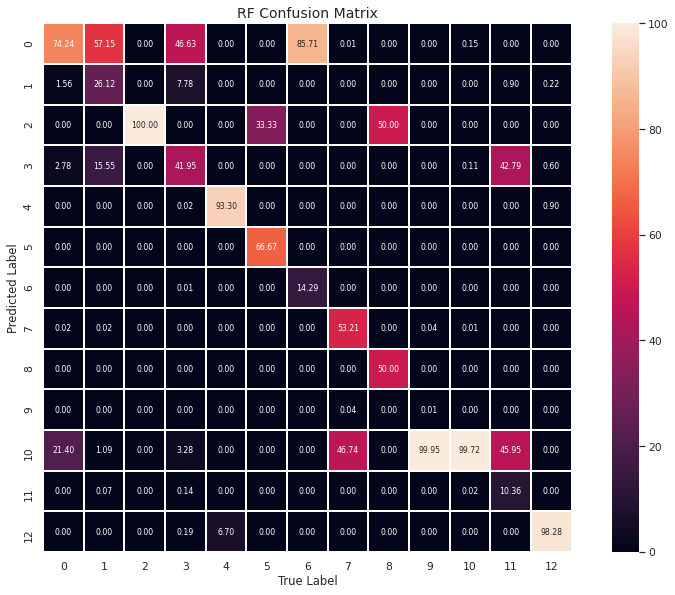

In [ ]:
evaluate(rf_classifier, xtest, ytest, ypred, 'RF Confusion Matrix')

# NAIVE BAYES



In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
nb_classifier.fit(xtrain, ytrain)

ypred = nb_classifier.predict(xtest)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.11      0.99      0.20       624
           2       0.00      0.00      0.00         0
           3       0.00      0.33      0.00         3
           4       0.00      0.00      0.00         0
           5       1.00      0.18      0.30        17
           6       0.14      0.50      0.22         2
           7       0.00      1.00      0.00         9
           8       0.50      0.33      0.40         6
           9       1.00      0.13      0.23    118197
          10       0.00      1.00      0.00        26
          11       0.00      0.00      0.00         0
          12       0.49      0.97      0.65       666

    accuracy                           0.14    119550
   macro avg       0.25      0.42      0.15    119550
weighted avg       0.99      0.14      0.23    119550



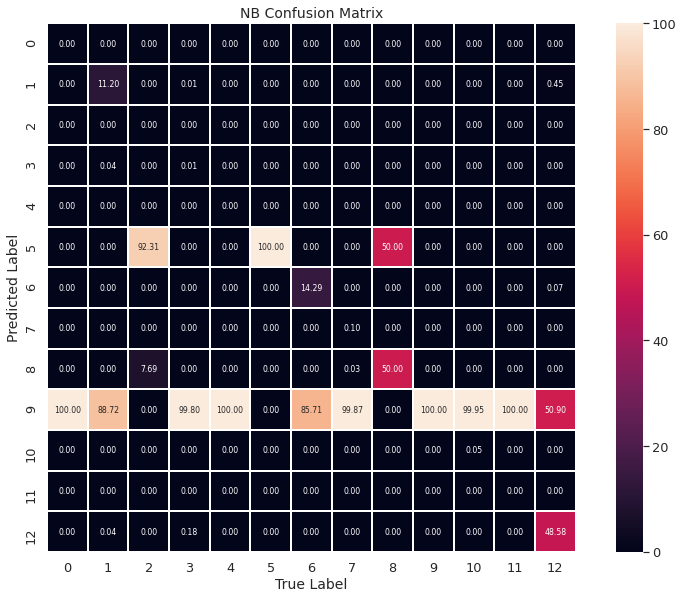

In [ ]:
evaluate(nb_classifier, xtest, ytest, ypred, 'NB Confusion Matrix')

# DECISION TREE


**Validation**

In [ ]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

xtrain_val, xval, ytrain_val, yval = train_test_split(xtrain, ytrain, random_state=0, test_size=0.2)

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(xtrain_val, ytrain_val)
tree_model = clf.best_estimator_

print(clf.best_score_, clf.best_params_)

0.704311694945849 {'max_depth': 11}


**Train**

In [ ]:
from sklearn import tree

dt_classifier = tree.DecisionTreeClassifier(max_depth=clf.best_params_['max_depth']) 
dt_classifier = dt_classifier.fit(xtrain, ytrain)

ypred = dt_classifier.predict(xtest)

              precision    recall  f1-score   support

           0       0.75      0.72      0.74     27188
           1       0.19      0.90      0.32      1170
           2       1.00      0.81      0.90        16
           3       0.47      0.64      0.54      6092
           4       0.95      0.90      0.93       219
           5       0.67      1.00      0.80         2
           6       0.14      0.33      0.20         3
           7       0.53      1.00      0.69      4752
           8       0.50      1.00      0.67         2
           9       0.00      0.00      0.00         3
          10       1.00      0.68      0.81     78739
          11       0.07      0.42      0.12        36
          12       0.97      0.98      0.98      1328

    accuracy                           0.70    119550
   macro avg       0.56      0.72      0.59    119550
weighted avg       0.89      0.70      0.77    119550



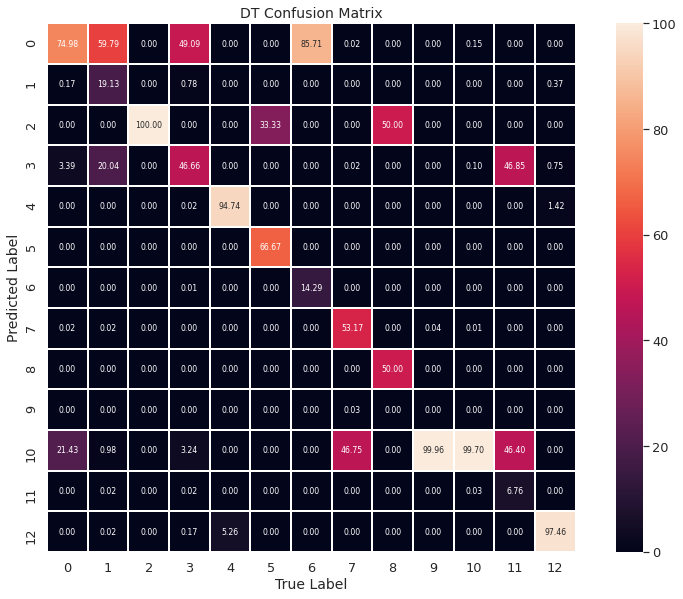

In [ ]:
evaluate(dt_classifier, xtest, ytest, ypred, 'DT Confusion Matrix')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=20)
knn_classifier = knn_classifier.fit(xtrain, ytrain)

ypred = knn_classifier.predict(xtest)

In [ ]:
evaluate(knn_classifier, xtest, ytest, ypred, 'KNN Confusion Matrix')

In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import tree

dt_classifier = tree.DecisionTreeClassifier(max_depth=10) 
sfs = SequentialFeatureSelector(dt_classifier, 
                                n_features_to_select=None,
                                direction='backward',
                                scoring='f1_weighted')
sfs.fit(xtrain, ytrain)
sfs.get_support()